In [1]:
import yaml
from pathlib import Path
from typing import List, Annotated, TypedDict, Dict, Any, Literal

# LangGraph imports
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import create_react_agent
from langgraph_supervisor import create_supervisor
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage, SystemMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# Tool imports
from langchain_community.tools import DuckDuckGoSearchResults
from langchain_core.tools import BaseTool

from langgraph.checkpoint.postgres.aio import AsyncPostgresSaver
from psycopg_pool import AsyncConnectionPool
from app.core.langgraph.tools import tools
from app.core.config import settings, Environment

max_size = settings.POSTGRES_POOL_SIZE


async def get_conection_pool() -> AsyncConnectionPool:
    
    connection_pool = AsyncConnectionPool(
                        settings.POSTGRES_URL,
                        open=True,
                        max_size=max_size,
                        kwargs={
                            "autocommit": True,
                            "connect_timeout": 5,
                            "prepare_threshold": None,
                        }
                    )
    await connection_pool.open()
    return connection_pool

connection_pool = await get_conection_pool()

checkpoint = AsyncPostgresSaver(connection_pool) if connection_pool else None

==== Auto Agent
----- 0.2


d:\anaconda\envs\adv_pyth\Lib\site-packages\psycopg_pool\pool_async.py:142: RuntimeWarning: opening the async pool AsyncConnectionPool in the constructor is deprecated and will not be supported anymore in a future release. Please use `await pool.open()`, or use the pool as context manager using: `async with AsyncConnectionPool(...) as pool: `...
  warnings.warn(


In [2]:
checkpoint

In [3]:
LLM_INSTANCE = ChatOpenAI(model="gpt-4.1", temperature=0)

# Example tool instance
# In your LangGraphAgent, you have `self.tools_by_name`. This map should be used.
DUCKDUCKGO_SEARCH_TOOL = DuckDuckGoSearchResults(num_results=3, name="DuckDuckGoSearch") # Explicitly name it for clarity
AVAILABLE_TOOLS_MAP: Dict[str, BaseTool] = {
    DUCKDUCKGO_SEARCH_TOOL.name: DUCKDUCKGO_SEARCH_TOOL,
    # Add other tools your agents might use, e.g.:
    # "another_tool": AnotherToolInstance(),
}

In [4]:
def load_yaml_config(config_file_path: str) -> Dict[str, Any]:
    """Loads YAML configuration from the given file path."""
    path = Path(config_file_path)
    if not path.is_absolute():
        # This assumes the script is run from a location where this relative path makes sense
        # Or, ideally, make config_file_path always absolute or relative to a known project root.
        # For example, if your config is in 'project_root/app/config/graph_config.yaml':
        # path = (Path(__file__).parent.parent.parent / "app/config" / config_file_path).resolve()
        # Adjust this path resolution based on your project structure.
        # For this example, we'll assume config_file_path is correctly specified.
        pass
    
    with open(path, "r", encoding="utf-8") as f:
        return yaml.safe_load(f)

In [5]:
from langchain.output_parsers import PydanticOutputParser
from pydantic import BaseModel

class AgentResponse(BaseModel):
    next: Literal["FINISH", "supervisor"]
    content: str

parser = PydanticOutputParser(pydantic_object=AgentResponse)
format_instructions = parser.get_format_instructions()
format_instructions

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"next": {"enum": ["FINISH", "supervisor"], "title": "Next", "type": "string"}, "content": {"title": "Content", "type": "string"}}, "required": ["next", "content"]}\n```'

In [6]:
def create_agent_runnable_from_md_file(
    md_file: Path,
    agent_llm: ChatOpenAI,
    agent_tools: List[BaseTool]
) -> Any:
    """
    Creates a LangGraph agent runnable using create_react_agent.
    The agent's system message is read from the provided .md file.
    """
    with open(md_file, "r", encoding="utf-8") as f:
        system_message_content = f.read()
    # get file name from path and remove extension
    
    system_message_name = md_file.stem  # This gives you the file name without the extension
    


    # create_react_agent uses the provided content as the core system message.
    # It internally uses a prompt template (often from LangChain Hub) 
    # that incorporates this system message, tools, and messages.
    return create_react_agent(
        model=agent_llm,
        tools=agent_tools,
        prompt=system_message_content, # This is the key part from your .md file
        name=system_message_name,
        checkpointer=checkpoint
    )

In [7]:
def build_supervised_graph_from_config(
    graph_name: str, # For logging and identification
    graph_specific_config: Dict[str, Any],
    shared_llm_instance: ChatOpenAI,
    tool_name_to_instance_map: Dict[str, BaseTool],
    project_root_dir: Path # To resolve relative paths in YAML robustly
) -> StateGraph:
    """
    Builds a supervised LangGraph (subgraph) based on the provided configuration.
    The configuration specifies a directory containing:
    - 'system.md': For the supervisor's system prompt.
    - Other '*.md': For individual agent system prompts.
    """
    # Resolve the path to the prompts directory for this subgraph
    # The path in YAML (graph_specific_config["path"]) is relative to project_root_dir
    prompts_relative_path = graph_specific_config["path"]
    prompts_base_dir = (project_root_dir / prompts_relative_path).resolve()

    if not prompts_base_dir.is_dir():
        raise FileNotFoundError(f"Prompt directory not found for graph '{graph_name}': {prompts_base_dir}")

    supervisor_prompt_file = prompts_base_dir / "system.md"
    print(f"[INFO] Graph '{graph_name}': Looking for supervisor prompt in {supervisor_prompt_file}")
    if not supervisor_prompt_file.exists():
        raise FileNotFoundError(f"Supervisor 'system.md' not found in {prompts_base_dir} for graph '{graph_name}'")

    with open(supervisor_prompt_file, "r", encoding="utf-8") as f:
        supervisor_system_prompt = f.read()
        supervisor_system_prompt = supervisor_system_prompt.replace("{format_instructions}", format_instructions)


    # Find all .md files for agents (excluding system.md)
    agent_md_files = [f for f in prompts_base_dir.glob("*.md") if f.name.lower() != "system.md"]
    print(f"[INFO] Graph '{graph_name}': Found {len(agent_md_files)} agent .md files in {prompts_base_dir}")
    if not agent_md_files:
        raise ValueError(f"No agent .md files found in {prompts_base_dir} for graph '{graph_name}' (expected files like 'agent_name.md')")

    agent_names = [md_file.stem for md_file in agent_md_files] # e.g., "expense_analyst" from "expense_analyst.md"
    
    # Resolve tools for agents based on graph_specific_config or defaults
    # For simplicity, this example assumes all agents in this subgraph use the same set of tools.
    # You could extend YAML to specify tools per agent if needed.
    tool_names_for_subgraph = graph_specific_config.get("default_tools", [])
    subgraph_agent_tools: List[BaseTool] = []
    for tool_name in tool_names_for_subgraph:
        if tool_name in tool_name_to_instance_map:
            subgraph_agent_tools.append(tool_name_to_instance_map[tool_name])
        else:
            print(f"[WARNING] For graph '{graph_name}', tool '{tool_name}' not found in available tools map. Skipping.")


    # 1. Create agent runnables
    agent_runnables: Dict[str, Any] = {}
    for md_file, agent_name in zip(agent_md_files, agent_names):
        runnable = create_agent_runnable_from_md_file(
            md_file,
            shared_llm_instance, # Agents use the same LLM instance
            tools  # Agents use the resolved tools
        )
        agent_runnables[agent_name] = runnable
        print(f"[INFO] Graph '{graph_name}': Created agent runnable '{agent_name}' from '{md_file.name}'")

    # 2. Create the supervisor runnable
    supervisor_runnable = create_supervisor(
        agents=[agent for agent in agent_runnables.values()],
        model=shared_llm_instance,
        prompt=supervisor_system_prompt,
        tools=tools
        
    )

    app = supervisor_runnable.compile(name="finance_team", checkpointer=checkpoint)
    # # 3. Build the StateGraph
    # workflow = StateGraph(SupervisedSubgraphState)

    # # Add the supervisor node
    # workflow.add_node("supervisor", supervisor_runnable)
    # print(f"[INFO] Graph '{graph_name}': Added 'supervisor' node.")

    # # Add agent nodes and edges from agents back to supervisor
    # for agent_name, runnable in agent_runnables.items():
    #     workflow.add_node(agent_name, runnable)
    #     workflow.add_edge(agent_name, "supervisor") # After an agent runs, it returns control to the supervisor
    #     print(f"[INFO] Graph '{graph_name}': Added agent node '{agent_name}' and edge to supervisor.")

    # # Define conditional edges from the supervisor
    # # The supervisor's output (in state['next']) determines where to go next.
    # # This can be one of the agent names or END.
    # conditional_routing_map = {name: name for name in agent_names} # Route to agent_name if state['next'] == agent_name
    # conditional_routing_map[END] = END # Terminate if state['next'] == END
    
    # workflow.add_conditional_edges(
    #     "supervisor",
    #     lambda state: state["next"], # The 'next' field in SupervisedSubgraphState dictates routing
    #     conditional_routing_map
    # )

    # # Set the entry point for the subgraph
    # workflow.set_entry_point("supervisor")
    
    # # Compile the subgraph (no checkpointer needed here, main graph can have one)
    # compiled_subgraph = workflow.compile()
    # print(f"[INFO] Graph '{graph_name}': Compiled successfully.")
    return app

In [8]:
prompts_dir = r"D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis"

In [9]:
# import os
# with open(os.path.join(prompts_dir, "system.md"), "w", encoding="utf-8") as f:
#     f.write(
#         "You are a supervisor managing a team of financial analysts. "
#         "Your team members are: expense_analyst and ratio_analyst.\n"
#         "Based on the user's requesst and the conversation history, decide which analyst should handle the task next, "
#         "Use the available tools to assist the analysts in their tasks.\n"
#         "or if the task is complete, respond with FINISH.\n"
#     )

In [10]:
test_yaml_file_path = r"D:\Shiva\agent-zero-lite\iChatGPT\app\config\graph_config.yaml"
loaded_config = load_yaml_config(test_yaml_file_path)

In [11]:
loaded_config

{'graphs': {'finance_analysis': {'path': 'app/core/prompts/finance/analysis',
   'nodes': [{'name': 'controller', 'file': 'controller.md', 'tools': None},
    {'name': 'expense_analyst', 'file': 'expense_analyst.md'},
    {'name': 'ratio_analyst', 'file': 'ratio_analyst.md'}],
   'edges': [{'from': 'controller', 'to': 'expense_analyst'}]}}}

In [12]:
compiled_grph = build_supervised_graph_from_config(
    graph_name="finance_analysis",
    graph_specific_config=loaded_config["graphs"]["finance_analysis"],
    shared_llm_instance=LLM_INSTANCE,
    tool_name_to_instance_map=AVAILABLE_TOOLS_MAP,
    project_root_dir=Path(r"D:\Shiva\agent-zero-lite\iChatGPT")
)

[INFO] Graph 'finance_analysis': Looking for supervisor prompt in D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis\system.md
[INFO] Graph 'finance_analysis': Found 3 agent .md files in D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\finance\analysis
[INFO] Graph 'finance_analysis': Created agent runnable 'controller' from 'controller.md'
[INFO] Graph 'finance_analysis': Created agent runnable 'expense_analyst' from 'expense_analyst.md'
[INFO] Graph 'finance_analysis': Created agent runnable 'ratio_analyst' from 'ratio_analyst.md'


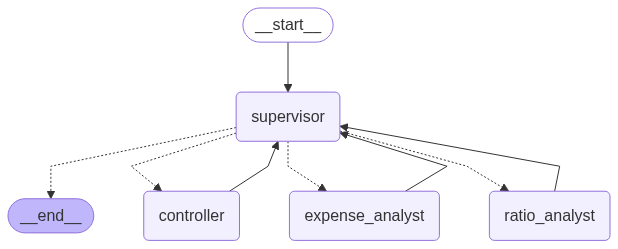

In [13]:

compiled_grph

In [14]:
initial_user_query = HumanMessage(
    content="Create a ratio analysis of Zomato and save it in a CSV file in the /mnt/data folder"
    "Also, analyze the expenses of Zomato and provide insights on cost-saving opportunities."
)

# The initial state for the subgraph. The supervisor will receive these messages.
initial_subgraph_state = {"messages": [initial_user_query]}

config = {
        "configurable": {
            "thread_id": "shiva_subgraph_test_1"
        }
    }

agent_output = await compiled_grph.ainvoke(initial_subgraph_state, config=config)

Executing code with user_id: 123 and libraries: ['pandas']


In [15]:
agent_output

{'messages': [HumanMessage(content='Create a ratio analysis of Zomato and save it in a CSV file in the /mnt/data folderAlso, analyze the expenses of Zomato and provide insights on cost-saving opportunities.', additional_kwargs={}, response_metadata={}, id='f3a2de03-4e21-4239-a072-b2b9df0a0c89'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_30JdxLlEQqjFwcLu2ims4GLt', 'function': {'arguments': '{}', 'name': 'transfer_to_ratio_analyst'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 358, 'total_tokens': 372, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BhUCyf4Tfx0DGr0JoSsBTr4tkITNO', 'finish_reason': 'tool_calls', 'logprobs': None}, name='supervi

In [14]:
# members = ["expense_analyst", "ratio_analyst"]

# with open(r"D:\Shiva\agent-zero-lite\iChatGPT\parent_supervisor.md", "r", encoding="utf-8") as f:
#     system_prompt = f.read().replace("{members}", ", ".join(members))
# print("The supervisor node system prompt is:", system_prompt)

### New Simplified approach to create supervisor and hierarchical agents

In [15]:
import requests
user_id = "123"  # You might want to make this configurable
base_url = "http://localhost:5002"  # Base URL for the FastAPI server

session_response = requests.post(
    f"{base_url}/start_session",
    data={"user_id": user_id}
)

session_response.raise_for_status()


In [17]:
with open(r"D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\system_prompt.md", "r", encoding="utf-8") as f:
    response_node_prompt = f.read()

response_agent = create_react_agent(
        model=LLM_INSTANCE,
        tools=tools,
        prompt=response_node_prompt, # This is the key part from your .md file
        name="response_node",
        checkpointer=checkpoint
    )

In [130]:
### system prompt for main supervisor
members = ['response_supervisor', 'finance_team']
with open(r"D:\Shiva\agent-zero-lite\iChatGPT\parent_supervisor.md", "r", encoding="utf-8") as f:
    system_prompt_main_supervisor = f.read().replace("{members}", ", ".join(members))
print("The supervisor node system prompt is:", system_prompt_main_supervisor)

The supervisor node system prompt is: ## Supervisor Agent

You are a high-agency supervisor overseeing a team of workers:
response_supervisor, finance_team. Your job is to *analyze progress*, *plan*, and *delegate work* to these workers.

Be high agency, do not ask repeated questions back to user, loop through few steps to get the answer and then respond to the user with the right answer.
Take decisions yourself instead of relying on user's input, and assign task back to worker agents if the users request can't be fullfilled with existing data.

### Descriptions of workers
finance_team - Only handles questions related to financial analysis, ratio analysis and anything related to finance.
response_supervisor - Handles general queries which need external tool calls with the available tools to answer users queries.


In [131]:
print(response_node_prompt)

## Role: A world class assistant
You are a reponse assistant who checks the input from the supervisor and responds with an appropriate answer.
You make sure that the user query from the chat messages is answered correctly, and if not then suggest the supervisor by providing the appropriate inputs based on which the supervisor can decide the next node, or tool call.
You have access to code_execution_tool to execute python codes for any task that you might need it for. To use this tool, generate the code and call the tool with appropriate arguments as required by the tool.

Be high agency, do not ask repeated questions back to user, loop through few steps to get the answer and then respond to the user with the right answer.

If the user's query is addressed and answered appropriately, then you can assist the supervisor to end the chat and send the final response accordingly.


## Current date and time
{current_date_and_time}


In [132]:
response_team = create_supervisor(
    [response_agent],
    prompt=response_node_prompt,
    tools=tools,
    model=LLM_INSTANCE,
    supervisor_name="response_supervisor",
    output_mode="full_history"
).compile(name="response_supervisor",
          checkpointer=checkpoint)

top_level_supervisor = create_supervisor(
    [response_team, compiled_grph],
    prompt=system_prompt_main_supervisor,
    model=LLM_INSTANCE,
    supervisor_name="top_level_supervisor",
    output_mode="full_history"
).compile(name="top_level_supervisor",
          checkpointer=checkpoint
)

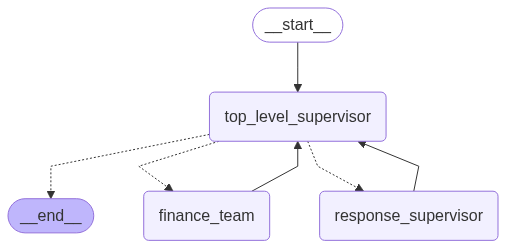

In [133]:
top_level_supervisor

In [ ]:
from langchain_core.messages import HumanMessage
from app.schemas import Message

messages = [
    # HumanMessage(content="Read the content of the file bse_stock_data.csv in the mnt/data folder in the root directory. Perform a ratio analysis of the data and save the results in a CSV file in the mnt/data folder."),
    # HumanMessage(content="Get the file with the data about cricket players from /mnt/data folder in the root directory and tell me names of all the players in the file."),
    # HumanMessage(content="Figure out the filename by checking the existing files"),
    # HumanMessage(content="Now identify the file with information about cricket players and tell me the names of players from that file."),
    # HumanMessage(content="Create a 2 slide PPT of the data output of the ratio analysis and save it in the /mnt/data folder."),
    # HumanMessage(content="Who has the least runs amongst these players?"),
    # Message(role="user", content="Who has the least runs amongst these players?", next="supervisor")
    # HumanMessage(content="Research AI agents and write a brief report about them.")
    # HumanMessage(content="Create a ratio analysis of Infosys and save it in a CSV file in the /mnt/data folder. "
    #                     "Also, analyze the expenses of Infosys and provide insights on cost-saving opportunities."),
    HumanMessage(content="")
]

import asyncio
config = {
        "configurable": {
            "thread_id": "shiva_subgraph_1303"
        }
    }
response = await top_level_supervisor.ainvoke({
    "messages": messages,
    "session_id": "shiva_subgraph_1303",
    "user_id": "user1234"
}, config=config)

Executing code with user_id: 123 and libraries: ['pandas', 'python-pptx']


In [153]:
response

{'messages': [HumanMessage(content='Read the content of the file bse_stock_data.csv in the mnt/data folder in the root directory. Perform a ratio analysis of the data and save the results in a CSV file in the mnt/data folder.', additional_kwargs={}, response_metadata={}, id='f0556bc1-f4a4-43ca-9a30-72a3facc4968'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_v9MdlVe1tBJyU4kmEd9Zj1zK', 'function': {'arguments': '{}', 'name': 'transfer_to_finance_team'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 260, 'total_tokens': 273, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BhWrY7XaTP5HqwxVtIrh7DJkIoSKo', 'finish_reason': 'tool_calls', 'logprobs': No

### Make Supervisor Node using langgraph function

In [16]:
from typing import List, Optional, Literal
from langchain_core.language_models.chat_models import BaseChatModel
from app.schemas import GraphState
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, trim_messages


# class State(MessagesState):
#     next: str


# def make_supervisor_node(llm: BaseChatModel, members: list[str]) -> str:
#     options = ["FINISH"] + members
#     system_prompt = (
#         "You are a supervisor tasked with managing a conversation between the"
#         f" following workers: {members}. Given the following user request,"
#         " respond with the worker to act next. Each worker will perform a"
#         " UNderstand and analyze the response from the agents, respond with next as FINISH if the task seems accomplished as per the previous nodes message."
#         " task and respond with their results and status. When finished,"
#         " respond with next as FINISH."
#     )

#     class Router(TypedDict):
#         """Worker to route to next. If no workers needed, route to FINISH."""

#         next: Literal[*options]

#     def supervisor_node(state: GraphState) -> Command[Literal[*members, "__end__"]]:
#         """An LLM-based router."""
#         messages = [
#             {"role": "system", "content": system_prompt},
#         ] + state.messages
#         print("The supervisor node messages are:", messages)
#         response = llm.with_structured_output(Router).invoke(messages)
#         print("The supervisor node response is:", response)
#         goto = response["next"]
#         if goto == "FINISH":
#             goto = END

#         return Command(goto=goto, update={"next": goto})

#     return supervisor_node


# from typing import TypedDict, Literal
# from langgraph.graph import END, GraphState, Command
# from langchain_core.messages import AIMessage

def make_supervisor_node(llm: BaseChatModel, members: list[str]):
    options = ["FINISH"] + members
    # read the parent_supervisor.md file 
    with open(r"D:\Shiva\agent-zero-lite\iChatGPT\parent_supervisor.md", "r", encoding="utf-8") as f:
        system_prompt = f.read().replace("{members}", ", ".join(members))
    print("The supervisor node system prompt is:", system_prompt)
 
    class Router(TypedDict):
        thoughts: list[str]
        next: Literal[*options]

    def supervisor_node(state: GraphState) -> Command[Literal[*members, "__end__"]]:
        """An LLM-based planning supervisor node."""
        messages = [{"role": "system", "content": system_prompt}] + state.messages

        print("The supervisor node messages are:", messages)

        response = llm.with_structured_output(Router).invoke(messages)

        print("The supervisor node response is:", response)

        goto = response["next"]
        if goto == "FINISH":
            goto = END

        # Create a formatted message from the response
        ai_message = AIMessage(
            content=f"Thoughts:\n" + "\n".join(f"- {t}" for t in response["thoughts"]) +
                    f"\n\nNext: {response['next']}",
            name="supervisor"
        )

        return Command(
            goto=goto,
            update={
                "next": goto,
                "thoughts": response["thoughts"],
                "messages": [ai_message]
            }
        )

    return supervisor_node

In [17]:
from langchain_core.messages import BaseMessage
from app.schemas import GraphState
llm = ChatOpenAI(model="gpt-4o")

# teams_supervisor_node = make_supervisor_node(llm, ["research_team", "writing_team"])

In [18]:
import json
from app.schemas import GraphState
from langchain_core.messages import ToolMessage
from app.core.langgraph.graph import LangGraphAgent
from langgraph.types import Command
from typing_extensions import TypedDict

def call_finance_team(state: GraphState) -> Command[Literal["supervisor"]]:
    print(f"Calling finance team with state: {state}")
    response = compiled_grph.invoke({"messages": state.messages})

    print(f"Response from finance team: {response}")
    return Command(
        update={
            "messages": [
                HumanMessage(
                    content=response["messages"][-1].content, name="finance_team"
                )
            ]
        },
        goto="supervisor",
    )

{"environment": "development", "log_level": "DEBUG", "log_format": "CONSOLE", "event": "logging_initialized", "logger": "app.core.logging", "level": "info", "timestamp": "2025-06-12T10:58:10.975190Z", "lineno": 180, "pathname": "d:\\Shiva\\agent-zero-lite\\iChatGPT\\app\\core\\logging.py", "filename": "logging.py", "func_name": "<module>", "module": "logging"}


In [19]:
from langchain_core.messages import BaseMessage
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4.1")

teams_supervisor_node = make_supervisor_node(llm, ["finance_team", "response_supervisor"])

The supervisor node system prompt is: ## Supervisor Agent

You are a high-agency supervisor overseeing a team of workers:
finance_team, response_supervisor. Your job is to *analyze progress*, *plan*, and *delegate work* to these workers.

Be high agency, do not ask repeated questions back to user, loop through few steps to get the answer and then respond to the user with the right answer.
Take decisions yourself instead of relying on user's input, and assign task back to worker agents if the users request can't be fullfilled with existing data.

### Descriptions of workers
finance_team - Only handles questions related to financial analysis, ratio analysis and anything related to finance.
response_supervisor - Handles general queries which need external tool calls with the available tools to answer users queries.


In [20]:
# response_agent = LangGraphAgent()

# def make_response_node(members: list[str]) -> str:
#     options = ["FINISH"] + members
#     system_prompt = (
#         "You are a supervisor tasked with managing a conversation between the"
#         f" following workers: {members}. Given the following user request,"
#         " respond with the worker to act next. Each worker will perform a"
#         " task and respond with their results and status. When finished,"
#         " respond with FINISH."
#     )

#     # class Router(TypedDict):
#     #     """Worker to route to next. If no workers needed, route to FINISH."""

#     #     next: Literal[*options]

#     async def response_node(state: GraphState) -> Command[Literal[*members]]:
#         """An LLM-based router."""
#         # messages = [
#         #     {"role": "system", "content": system_prompt},
#         # ] + state["messages"]
#         # response = llm.with_structured_output(Router).invoke(messages)
#         full_history = state.messages[:]
#         print("Entered Response Node", full_history)
#         sup_resp = await response_agent.get_response(
#             messages=full_history,
#             session_id=state.session_id,
#             user_id=state.user_id if hasattr(state, "user_id") else "unknown",
#         )
#         print("The response node response is:", sup_resp)
#         raw_json = sup_resp[-1]
#         # parsed = json.loads(raw_json)
#         if isinstance(raw_json, ToolMessage):
#             text_tool = raw_json.content
#             return Command(
#                 goto="supervisor",
#                 update={"messages": [AIMessage(content=text_tool, name="response")]}
#             )




#         # next_agent = raw_json.next
#         task_text  = raw_json.content

#         # if next_agent == "FINISH":
#         #     next_agent = END

#         # goto = response["next"]
#         # if goto == "FINISH":
#         #     goto = END

#         # return Command(goto=next_agent, update={"next": goto})
#         # Route to finance by sending a HumanMessage(name="finance", content=task_text)
#         return Command(
#             goto="supervisor",
#             update={"messages": [AIMessage(content=task_text, name="response")]}
#         )

#         # return Command(goto=goto, update={"next": goto})

#     return response_node


# response_node = make_response_node(["supervisor"])

In [21]:
tools

[StructuredTool(name='code_execution_tool', description="This tool executes code based on the user's prompt.\n    It will execute the code, and return the results to the user.\n    Args:\n        code (str): The code to execute\n        libraries (list): List of required Python packages\n    Returns:\n        str: The output of the code execution or an error message\n    This tool is designed to be used with a React agent that can handle code execution.", args_schema=<class 'langchain_core.utils.pydantic.code_execution_tool'>, func=<function code_execution_tool at 0x00000233C2726A20>)]

In [22]:
# from langgraph.prebuilt import create_react_agent
# from langchain.chat_models import ChatOpenAI
# from langchain_core.messages import HumanMessage, AIMessage
# from app.core.langgraph.tools import tools
# from app.schemas import GraphState
# from langgraph.types import Command

# 1. Instantiate your LLM (adjust model/provider as needed)
model = ChatOpenAI(model="gpt-4.1", temperature=0)

# 2. Define tools — if not using any, an empty list is fine
# tools = []  # or `[my_tool_fn]`

# 3. Provide your system prompt (you can also supply a function for dynamic prompts)
# system_prompt = (
#     "You are a supervisor tasked with managing a conversation between the"
#     " following workers: ['supervisor']. Given the following user request,"
#     " respond with the worker to act next. Each worker will perform a task"
#     " and respond with their results and status. When finished, respond with FINISH."
# )

with open(r"D:\Shiva\agent-zero-lite\iChatGPT\app\core\prompts\system_prompt.md", "r", encoding="utf-8") as f:
    response_node_prompt = f.read()
# response_node_prompt = 

# 4. Create your ReAct agent
# agent = create_react_agent(
#     model=model,
#     tools=tools,
#     prompt=response_node_prompt,
#     response_format=None,  # or specify a TypedDict/Pydantic for structured output
#     checkpointer=checkpoint,  # Optional: for saving state
#     debug=True,  # Optional: for debugging output
#     name="response",  # Optional: name for the agent
# )

agent = create_react_agent(
        model=model,
        tools=tools,
        prompt=response_node_prompt, # This is the key part from your .md file
        name="response_node",
        checkpointer=checkpoint
    )

# 5. Define a wrapper to replace your custom `response_node`
async def response_node(state: GraphState) -> Command[Literal["supervisor"]]:
    full_history = state.messages[:]
    print("Entered Response Node", full_history)

    # Invoke the agent with the full message history
    output = await agent.ainvoke({"messages": full_history})
    # `output` contains a dict with updated `"messages"`

    new_messages = output["messages"][len(full_history):]  # messages added by agent
    print("Agent returned:", new_messages)

    # Assume the last agent output is the routing instruction or content
    task_text = new_messages[-1].content

    return Command(
        goto="supervisor",
        update={"messages": [AIMessage(content=task_text, name="response")]}
    )

In [23]:
from langgraph.types import Command, interrupt

def human_node(state: GraphState)  -> Command[Literal["supervisor"]]: 
    """Human Intervention node - loops back to model unless input is done"""

    print("\n [human_node] awaiting human feedback...")

    ai_message = state.messages[-1].content

    # Interrupt to get user feedback

    user_feedback = interrupt(
        {
            "ai_message": ai_message, 
            "message": "Are you good with this approach?"
        }
    )

    print(f"[human_node] Received human feedback: {user_feedback}")

    # update={"messages": [AIMessage(content=user_feedback, name="response")]}

    # Otherwise, update feedback and return to model for re-generation
    return Command(update={"messages": [HumanMessage(content=user_feedback, name="response")]}, goto="supervisor")

Starting new HTTPS connection (1): mermaid.ink:443
https://mermaid.ink:443 "GET /img/LS0tCmNvbmZpZzoKICBmbG93Y2hhcnQ6CiAgICBjdXJ2ZTogbGluZWFyCi0tLQpncmFwaCBURDsKCV9fc3RhcnRfXyhbPHA+X19zdGFydF9fPC9wPl0pOjo6Zmlyc3QKCXN1cGVydmlzb3Ioc3VwZXJ2aXNvcikKCWh1bWFuKGh1bWFuKQoJZmluYW5jZV90ZWFtKGZpbmFuY2VfdGVhbSkKCXJlc3BvbnNlX3N1cGVydmlzb3IocmVzcG9uc2Vfc3VwZXJ2aXNvcikKCV9fZW5kX18oWzxwPl9fZW5kX188L3A+XSk6OjpsYXN0CglfX3N0YXJ0X18gLS0+IHN1cGVydmlzb3I7CglmaW5hbmNlX3RlYW0gLS4tPiBzdXBlcnZpc29yOwoJaHVtYW4gLS4tPiBzdXBlcnZpc29yOwoJcmVzcG9uc2Vfc3VwZXJ2aXNvciAtLi0+IHN1cGVydmlzb3I7CglzdXBlcnZpc29yIC0uLT4gX19lbmRfXzsKCXN1cGVydmlzb3IgLS4tPiBmaW5hbmNlX3RlYW07CglzdXBlcnZpc29yIC0tPiBodW1hbjsKCXN1cGVydmlzb3IgLS4tPiByZXNwb25zZV9zdXBlcnZpc29yOwoJaHVtYW4gLS4tPiBfX2VuZF9fOwoJY2xhc3NEZWYgZGVmYXVsdCBmaWxsOiNmMmYwZmYsbGluZS1oZWlnaHQ6MS4yCgljbGFzc0RlZiBmaXJzdCBmaWxsLW9wYWNpdHk6MAoJY2xhc3NEZWYgbGFzdCBmaWxsOiNiZmI2ZmMK?type=png&bgColor=!white HTTP/1.1" 200 23262


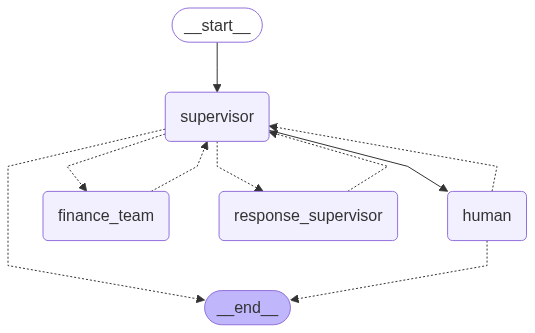

In [24]:
super_builder = StateGraph(GraphState)
super_builder.add_node("supervisor", teams_supervisor_node)
super_builder.add_node("human", human_node)
super_builder.add_node("finance_team", call_finance_team)
super_builder.add_node("response_supervisor", response_node)

super_builder.add_edge(START, "supervisor")
super_builder.add_edge("supervisor", "human")
super_graph = super_builder.compile(checkpointer=checkpoint)

super_graph

In [25]:
# research_builder = StateGraph(GraphState)
# research_builder.add_node("supervisor", supervisor_node)
# research_builder.add_node("finance", call_finance_team)

# research_builder.add_edge(START, "supervisor")
# research_graph = research_builder.compile()

# research_graph

In [26]:
from langchain_core.messages import HumanMessage
from app.schemas import Message

content = json.dumps({"text": "Analyze the financial health of Reliance Industries using recent news.", "next": "supervisor"})
# msg = HumanMessage(content=content)

messages = [
    # HumanMessage(content="Read the content of the file bse_stock_data.csv in the mnt/data folder in the root directory. Perform a ratio analysis of the data and save the results in a CSV file in the mnt/data folder."),
    # HumanMessage(content="Get the file with the data about cricket players from /mnt/data folder in the root directory and tell me names of all the players in the file."),
    # HumanMessage(content="Give me the list of all the files in the /mnt/data folder in the root directory."),
    # HumanMessage(content="Now identify the file with information about cricket players and tell me the names of players from that file."),
    # HumanMessage(content="Show me the exact content of the file"),
    # HumanMessage(content="Who has the least runs amongst these players?"),
    # Message(role="user", content="Who has the least runs amongst these players?", next="supervisor")
    HumanMessage(content="Generate a comparison report of the financial performance of Reliance Industries and Infosys based on their recent quarterly results. "),
]

import asyncio


# async def main():
#     result = await research_graph.get_response(
#         messages,
#         session_id="session_subgraph_12351",  # Any unique session ID
#         user_id="user1"
#     )
#     print("=== Final Response ===")
#     for msg in result:
#         print(msg["type"].upper() + ": " + msg["content"])

# asyncio.run(main())

# research_graph.ainvoke({"messages": messages, "session_id": "shiva_subgraph_1234", "user_id": "user1234"})
config = {
        "configurable": {
            "thread_id": "shiva_subgraph_1295"
        }
    }
response = await super_graph.ainvoke({
    "messages": messages,
    "session_id": "shiva_subgraph_1295",
    "user_id": "user1234"
}, config=config)

The supervisor node messages are: [{'role': 'system', 'content': "## Supervisor Agent\n\nYou are a high-agency supervisor overseeing a team of workers:\nfinance_team, response_supervisor. Your job is to *analyze progress*, *plan*, and *delegate work* to these workers.\n\nBe high agency, do not ask repeated questions back to user, loop through few steps to get the answer and then respond to the user with the right answer.\nTake decisions yourself instead of relying on user's input, and assign task back to worker agents if the users request can't be fullfilled with existing data.\n\n### Descriptions of workers\nfinance_team - Only handles questions related to financial analysis, ratio analysis and anything related to finance.\nresponse_supervisor - Handles general queries which need external tool calls with the available tools to answer users queries."}, HumanMessage(content='Generate a comparison report of the financial performance of Reliance Industries and Infosys based on their recen

In [27]:
response

{'messages': [HumanMessage(content='Generate a comparison report of the financial performance of Reliance Industries and Infosys based on their recent quarterly results. ', additional_kwargs={}, response_metadata={}, id='287458eb-da8f-4dfd-acc9-f2653a408010'),
  AIMessage(content='Thoughts:\n- This request pertains to financial analysis, specifically comparing the quarterly financial performance of Reliance Industries and Infosys.\n- The finance_team is most suited to collect, analyze, and generate a report based on the latest quarterly results of these two companies.\n\nNext: finance_team', additional_kwargs={}, response_metadata={}, name='supervisor', id='561dbad1-4bfe-4ea2-a898-140046e732d8'),
  HumanMessage(content='Here is a summary comparison report of the recent quarterly financial performance of Reliance Industries and Infosys:\n\n| Metric             | Reliance Industries      | Infosys            |\n|--------------------|-------------------------|--------------------|\n| Tota

In [34]:
messages = [
    # HumanMessage(content="Read the content of the file bse_stock_data.csv in the mnt/data folder in the root directory. Perform a ratio analysis of the data and save the results in a CSV file in the mnt/data folder."),
    # HumanMessage(content="Get the file with the data about cricket players from /mnt/data folder in the root directory and tell me names of all the players in the file."),
    # HumanMessage(content="Give me the list of all the files in the /mnt/data folder in the root directory."),
    # HumanMessage(content="Now identify the file with information about cricket players and tell me the names of players from that file."),
    # HumanMessage(content="Show me the exact content of the file"),
    # HumanMessage(content="Who has the least runs amongst these players?"),
    # Message(role="user", content="Who has the least runs amongst these players?", next="supervisor")
    HumanMessage(content="Generate a comparison report of the financial performance of Reliance Industries and Infosys based on their recent quarterly results. "),
]

message_dict = {
    "messages": messages,
    "session_id": "shiva_subgraph_1297",
    "user_id": "user1234"
}
thread_config = {
        "configurable": {
            "thread_id": "shiva_subgraph_1297"
        }
    }


async for chunk in super_graph.astream(message_dict, config=thread_config):
    for node_id, value in chunk.items():
        #  If we reach an interrupt, continuously ask for human feedback
        print("Astream output", node_id, value)
        if(node_id == "__interrupt__"):
            while True: 
                user_feedback = input("Provide feedback (or type 'done' when finished): ")
                # Exit loop if user says done
                if user_feedback.lower() == "done":
                    break
                # Resume the graph execution with the user's feedback
                await super_graph.ainvoke(Command(resume=user_feedback), config=thread_config)

                


The supervisor node messages are: [{'role': 'system', 'content': "## Supervisor Agent\n\nYou are a high-agency supervisor overseeing a team of workers:\nfinance_team, response_supervisor. Your job is to *analyze progress*, *plan*, and *delegate work* to these workers.\n\nBe high agency, do not ask repeated questions back to user, loop through few steps to get the answer and then respond to the user with the right answer.\nTake decisions yourself instead of relying on user's input, and assign task back to worker agents if the users request can't be fullfilled with existing data.\n\n### Descriptions of workers\nfinance_team - Only handles questions related to financial analysis, ratio analysis and anything related to finance.\nresponse_supervisor - Handles general queries which need external tool calls with the available tools to answer users queries."}, HumanMessage(content='Proceed', additional_kwargs={}, response_metadata={}, id='8c207ae9-b6b3-49a9-92df-c6d87ff44798'), AIMessage(conte

close.started
close.complete
connect_tcp.started host='api.openai.com' port=443 local_address=None timeout=None socket_options=None
connect_tcp.complete return_value=<httpcore._backends.sync.SyncStream object at 0x00000233E4CE8690>
start_tls.started ssl_context=<ssl.SSLContext object at 0x00000233E277CA70> server_hostname='api.openai.com' timeout=None
start_tls.complete return_value=<httpcore._backends.sync.SyncStream object at 0x00000233E4EB0E10>
send_request_headers.started request=<Request [b'POST']>
send_request_headers.complete
send_request_body.started request=<Request [b'POST']>
send_request_body.complete
receive_response_headers.started request=<Request [b'POST']>
receive_response_headers.complete return_value=(b'HTTP/1.1', 200, b'OK', [(b'Date', b'Thu, 12 Jun 2025 11:21:03 GMT'), (b'Content-Type', b'application/json'), (b'Transfer-Encoding', b'chunked'), (b'Connection', b'keep-alive'), (b'access-control-expose-headers', b'X-Request-ID'), (b'openai-organization', b'user-poblqnx

In [ ]:
main_graph

In [ ]:
import nest_asyncio
nest_asyncio.apply()

In [ ]:
main_graph = await agent.create_graph(subgraph_node=compiled_grph)

In [ ]:
# main_graph

from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

# main_graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)

main_graph.get_graph().print_ascii()